# exp049

exp048処理高速化

In [20]:
import os
import sys
import traceback
import gc
import time
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from collections import defaultdict

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import itertools

import warnings
warnings.simplefilter('ignore')

In [21]:
@dataclass
class Cfg:
    mode = "local_cv" # "local_cv" or "kaggle_inf" 
    exp_name = "exp049"
    input_dir = "/mnt/predict-student-performance-from-game-play/input/"
    output_dir = "/mnt/predict-student-performance-from-game-play/output/"
    prep_dir = "/mnt/predict-student-performance-from-game-play/prep/"
    seed = 42
    n_splits = 5
    best_threshold = 0.630 # local_cvの結果を入れる
cfg = Cfg()

if cfg.mode == "local_cv":
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)

elif cfg.mode == "kaggle_inf":
    import jo_wilder

In [22]:
params = {
    'objective': 'binary', 
    'boosting': 'gbdt', 
    'learning_rate': 0.01, 
    'metric': 'binary_logloss', 
    'seed': cfg.seed, 
    'feature_pre_filter': False, 
    'lambda_l1': 4.134488140102331, 
    'lambda_l2': 0.007775200046481757, 
    'num_leaves': 75, 
    'feature_fraction': 0.5, 
    'bagging_fraction': 0.7036110805680353, 
    'bagging_freq': 3, 
    'min_data_in_leaf': 50, 
    'min_child_samples': 100
} 

In [23]:
features_used_total = [
    'record_cnt'
]

In [24]:
level_group_list = ['0-4', '5-12', '13-22']

In [25]:
cat_col_lists = {'event_name': ['cutscene_click',
  'person_click',
  'navigate_click',
  'observation_click',
  'notification_click',
  'object_click',
  'object_hover',
  'map_hover',
  'map_click',
  'checkpoint',
  'notebook_click'],
 'name': ['basic', 'undefined', 'close', 'open', 'prev', 'next'],
 'level': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 'page': [0.0, 1.0, 3.0, 4.0, 5.0, 6.0, 2.0],
 'text': ['undefined',
  'Whatcha doing over there, Jo?',
  'Just talking to Teddy.',
  'I gotta run to my meeting!',
  'Can I come, Gramps?',
  'Sure thing, Jo. Grab your notebook and come upstairs!',
  'See you later, Teddy.',
  "I get to go to Gramps's meeting!",
  'Now where did I put my notebook?',
  '\\u00f0\\u0178\\u02dc\\u00b4',
  'I love these photos of me and Teddy!',
  'Found it!',
  'Gramps is in trouble for losing papers?',
  "This can't be right!",
  'Gramps is a great historian!',
  "Hmm. Button's still not working.",
  "Let's get started. The Wisconsin Wonders exhibit opens tomorrow!",
  'Who wants to investigate the shirt artifact?',
  "Not Leopold here. He's been losing papers lately.",
  'Hey!',
  "It's true, they do keep going missing lately.",
  'See?',
  'Besides, I already figured out the shirt.',
  "It's a women's basketball jersey!",
  'That settles it.',
  'Wells, finish up your report.',
  "Leopold, why don't you help me set up in the Capitol?",
  'We need to talk about that missing paperwork.',
  'Will do, Boss.',
  "Hey Jo, let's take a look at the shirt!",
  'Your grampa is waiting for you in the collection room.',
  "Why don't you go catch up with your grampa?",
  'What a fascinating artifact!',
  "Wow, that's so cool, Gramps!",
  'Can I take a closer look?',
  "Hmmm. Shouldn't you be doing your homework?",
  "It's already all done!",
  'Plus, my teacher said I could help you out for extra credit!',
  "Well, that's good enough for me.",
  'Go ahead, take a peek at the shirt!',
  'This looks like a clue!',
  "I'll record this in my notebook.",
  'Find anything?',
  'Yes! This old slip from 1916.',
  'I knew it!',
  "I'm not so sure that this is a basketball jersey.",
  'Wait, you mean Wells is wrong?!',
  'Could be. But we need evidence!',
  "Why don't you head to the Basketball Center and rustle up some clues?",
  'Sure!',
  "I'll be at the Capitol. Let me know if you find anything!",
  'Better check back later.',
  "That's it!",
  "The slip is from 1916 but the team didn't start until 1974!",
  'Our shirt is too old to be a basketball jersey!',
  'I need to get to the Capitol and tell Gramps!',
  'What are you still doing here,  Jolie?',
  'Go find your grampa and get to work!',
  'Oh no!',
  'What happened here?!',
  "I don't know!",
  'I got here and the whole place was a mess!',
  'Can you help me tidy up?',
  "Teddy's scarf! Somebody must've taken him!",
  'Try not to panic, Jo.',
  'Maybe he just got scared and ran off.',
  'But he never goes anywhere without his scarf!',
  "I think he's in trouble!",
  'Is this your coffee, Gramps?',
  "Nope, that's from Bean Town. I only drink Holdgers!",
  "Who could've done this?",
  "It must've been Wells.",
  "He's always trying to get you in trouble, and he doesn't like animals!",
  'Slow down, Jo.',
  'But what if Wells kidnapped Teddy?',
  'Then we need evidence.',
  "You're right, Gramps. Let's investigate!",
  "I'm afraid my papers have gone missing in this mess.",
  "You'll have to get started without me.",
  "Okay. I'll find Teddy!",
  "And I'll figure out the shirt, too.",
  'I knew I could count on you, Jo!',
  "Why don't you go upstairs and see the archivist?",
  "He's our expert record keeper.",
  'I need your help!',
  'Who are you?',
  "I'm Leopold's grandkid!",
  "Sorry, I'm too busy for kids right now.",
  'Now if only I could read this thing.',
  "Can't believe I lost my reading glasses.",
  'I bet the archivist could use this!',
  "Ah, that's better!",
  'Did you have a question?',
  'Yes! I was wondering-',
  'Wait a minute!',
  'Where did you get that coffee?',
  "Oh, that's from Bean Town.",
  'I ran into Wells there this morning.',
  'Wells? I knew it!',
  'Do you know anything about this slip?',
  'I found it on an old shirt.',
  'An old shirt? Try the university.',
  'You can talk to a textile expert there.',
  "What's a textile expert?",
  'They study clothes and fabric.',
  'Great! Thanks for the help!',
  'Head over to the university.',
  'Hello there!',
  'Wow! What is all this stuff?',
  "It's our Norwegian Craft exhibit!",
  'Can I give you the tour?',
  "Sorry, I'm in a hurry.",
  'Do you know what this slip is?',
  'Looks like a dry cleaning receipt.',
  'Thanks.',
  'Now I Just need to find all the cleaners from way back in 1916.',
  'Maybe I can help!',
  "I've got a stack of business cards from my favorite cleaners.",
  "Why don't you take a look?",
  'This place was around in 1916! I can start there!',
  "You haven't seen any badgers around here, have you?",
  'Badgers? No.',
  'Okay. Thanks anyway.',
  'Hi! How can I help you?',
  'I need to find the owner of this slip.',
  "Well, I can't show our log books to just anybody.",
  'Please?',
  "It's for Grampa Leo. He's a historian!",
  'Leo... you mean Leopold?',
  'Your gramps is awesome! Always full of stories.',
  "Guess it couldn't hurt to let you take a look.",
  "Here's the log book.",
  "It's a match!",
  'Theodora Youmans must be the owner!',
  'Do you know who Theodora Youmans is?',
  "Hmmm... not sure. Why don't you try the library?",
  'Thanks for the help!',
  'Oh, hello there!',
  'How can I help you?',
  'Have you seen a badger around here?',
  "I'm afraid not.",
  'Please let me know if you do.',
  "I'm also looking for Theodora Youmans. Have you heard of her?",
  'Theodora Youmans? Of course!',
  "Check out our microfiche. It's right through that door.",
  'Youmans was a suffragist!',
  'She helped get votes for women!',
  'Wells! What was he doing here? I should ask the librarian.',
  'What was Wells doing here?',
  'He was looking for a taxidermist.',
  "What's a taxidermist?",
  'Not sure. Here, let me look it up.',
  '\\Taxidermy: the art of preparing, stuffing, and mounting the skins of animals.\\',
  'Oh no... Teddy!',
  'Can you help me find Wells?',
  'You could ask the archivist. He knows everybody!',
  "Jolie! I was hoping you'd stop by. Any news on the shirt artifact?",
  "I haven't quite figured it out just yet...",
  "Well, get on it. I'm counting on you and your gramps to figure this out!",
  'Can you help me? I need to find Wells!',
  "I haven't seen him.",
  'Please? This is really important.',
  "Sorry, can't help you.",
  'Do you have any info on Theodora Youmans?',
  'Theodora Youmans? Is that who owned the shirt?',
  'Yep.',
  "Why didn't you say so?",
  'Youmans was a suffragist here in Wisconsin.',
  'She led marches and helped women get the right to vote!',
  "Wait a sec. Women couldn't vote?!",
  'Nope. But Youmans and other suffragists worked hard to change that.',
  'Thanks to them, Wisconsin was the first state to approve votes for women!',
  'Wow!',
  "Here's a call number to find more info in the Stacks.",
  'Where are the Stacks?',
  'Right outside the door.',
  'Hey, this is Youmans!',
  "And look! She's wearing the shirt!",
  'I should go to the Capitol and tell everyone!',
  'Jo!',
  'Check out the next artifact!',
  'What is it?',
  "I think it's a flag! Pretty interesting, huh?",
  "It's really cool, Gramps. But I'm worried about Teddy.",
  "He's still missing!",
  "We'll find him, Jo.",
  'Want to look for more clues?',
  "We'll find Teddy.",
  'We just have to keep our eyes open!',
  'Hey, look at those scratches!',
  'The kidnapper probably took Teddy on the elevator!',
  "You're right, Jo!",
  "Why isn't the button working?",
  "We'll need a key card.",
  'I had one, but Teddy chewed it up.',
  "I've got Wells's ID!",
  'What should we do next?',
  "I need to take the artifact upstairs. Why don't you investigate those scratch marks?",
  "Okay. I'll try.",
  'Teddy, here I come!',
  'I wonder whose glasses these are.',
  'Teddy!!!',
  "Hang on. I'll get you out of there!",
  'Whoever lost these glasses probably took Teddy!',
  'How can I find out whose glasses these are?',
  'Oh! There was a staff directory in the entryway!',
  "I'll go look at everyone's pictures!",
  'Those are the same glasses!',
  "The archivist must've taken Teddy!",
  "Yes! It's the key for Teddy's cage!",
  'I found the key!',
  "Come on, let's get out of here!",
  "Here's your scarf back!",
  'What are you doing down here?',
  'And how did that badger get free?',
  "I'm here to rescue my friend!",
  "What's going on here?",
  'Thanks for coming, Boss.',
  'I told you!',
  'I captured a badger in our museum!',
  "He's been eating my lunch every day this week!",
  'He has??',
  "I've seen him eating homework and important papers, too.",
  "Jolie- keep your badger under control, or he'll have to go.",
  'And you, Frank-',
  "You can't just steal Jolie's pet.",
  'Ugh. Fine.',
  'Alright, Jolie. Back to work.',
  "Come on, Teddy. Let's go help Gramps!",
  "Let's go help Gramps!",
  'Gramps must be up in the collection room.',
  "Let's go find him!",
  "Teddy! I'm glad to see you.",
  'The archivist had him locked up!',
  'Poor badger.',
  "You're becoming quite the detective, Jo.",
  'Notice any clues about this flag?',
  'Well... it looks hand-stitched.',
  'Good catch!',
  'Go on, tell the boss what you found!',
  "I'm telling you, Boss. Taxidermy is the way to go!",
  'Nonsense. I want live animals at the exhibit, not stuffed ones.',
  "Ah, Jolie! I'm glad you're here.",
  "I'm putting you in charge of the flag case.",
  'Make sure to get some old photos for the exhibit, like last time!',
  "Wait! Can't I do it?",
  'The symbol on the flag looks sort of like a deer hoof.',
  'It could be an early design for the Wisconsin state flag!',
  'Wells, you already have a job to do.',
  'What now, kid?',
  'Do you really think that symbol is a deer hoof?',
  'Not sure.',
  'Do you know where I can find a deer expert?',
  'Hmm. You could try the Aldo Leopold Wildlife Center.',
  'I have to head over there and check out the animals.',
  "I'll ride with you!",
  "Come on, kid. Let's go.",
  'Head over to the Wildlife Center!',
  "I'm sure they'll be able to help.",
  'People sure drink a lot of coffee around here.',
  "I can't believe this.",
  'Ugh...',
  'Oh no! What happened to that crane?',
  'Her beak is stuck in a coffee cup.',
  "It's lucky we found her.",
  'Ugh! Those cups are all over the place.',
  "I need to get her free. She won't hold still!",
  'Can Teddy and I help?',
  'Sure! Give it a try.',
  'Careful. That beak is sharp!',
  'We need to calm her down, Teddy.',
  'Any ideas?',
  '\\u00f0\\u0178\\u00a6\\u2014',
  'Oh yeah, cranes eat insects!',
  'Luckily there are tons of insects around here...',
  'Got one!',
  "Maybe she'll let me take off the cup!",
  "It's OK, girl! Look, I found you a cricket!",
  'You did it! Thanks, kid.',
  'Can I help you with anything?',
  "I'm investigating this symbol.",
  'Does it look like a deer hoof?',
  "There's a diagram of animal tracks over there.",
  'Go take a look!',
  "That hoofprint doesn't match the flag!",
  'Thanks for your help, kid!',
  "So? What'd you find out?",
  "Looks like it's not a deer hoof.",
  "Oh no. If I don't impress the boss soon,  I'm gonna get fired!",
  'Hey, Wells...',
  'I think I might be able to help you.',
  "No thanks. I don't need help from kids.",
  'Are you sure? I know where you can find a real, live badger for the exhibit!',
  'Wait! What?! Really?',
  'Wells, meet Teddy.',
  '\\u00f0\\u0178\\u02dc\\u0160',
  "He says he'd be willing to help out.",
  'Yes!!!',
  'We still need to figure out that flag. Do you know anyone who could help?',
  "Hmm. Let's see...",
  'Actually, I went to school with somebody who LOVES old flags.',
  "Why don't you go talk to her? I'll let her know you're coming.",
  'Hey, nice dog! What breed is he?',
  "Actually, he's a badger.",
  "Oh, cool! I've never seen a badger in real life.",
  "You've got a million flags here!",
  "Yep. I'm a vexillophile!",
  "What's a vexillophile? ",
  'It just means flag expert. How can I help?',
  "I'm investigating this flag.",
  'Can you take a look?',
  "Hey, I've seen that symbol before! Check it out!",
  '\\Ecology flag, by Ron Cobb.\\',
  "It's an ecology flag!",
  'Do you know what this flag was used for?',
  "I'm not sure.",
  "If I were you, I'd go to the library and do some digging.",
  'Good idea. Thanks!',
  'Welcome back, Dear! How can I help you?',
  'I need to learn more about this flag!',
  'It has something to do with ecology.',
  'Hmm... those stripes remind me of the American flag.',
  'Your flag must have been part of a national movement!',
  "Go check the microfiche. Maybe you'll find something!",
  "Hey! That's Governor Nelson in front of our flag!",
  'I found the flag! Governor Nelson used it on the first Earth Day!',
  'Wow! You figured it out!',
  'Now I just need some old photos, like last time.',
  'The boss is gonna love it!',
  'You could try the archives.',
  'Though the archivist might be too busy to help...',
  'Okay. Thanks!',
  'What are you doing here?',
  "We're looking for some photos.",
  "It's for the flag display!",
  'Wait a minute...',
  "YOU'RE the new history detective everybody's talking about?",
  "Teddy's helping too.",
  'What kind of photos do you need?',
  'Something to do with ecology and Wisconsin.',
  "Here's a call number for the Stacks. Go find some photos.",
  'Look at all those activists!',
  'This is perfect for the exhibit.',
  'I should go to the Capitol and tell Mrs. M!',
  'I should see what Grampa is up to!',
  'What should I do first?',
  'Head upstairs and talk to the archivist. He might be able to help!',
  "It's locked!",
  "Jolie! I was hoping you'd stop by. Any news on the flag artifact?",
  "Well, get on it. I'm counting on you to figure this out!",
  'Nice seeing you, Jolie!',
  "It's such a nice fall day.",
  'I love these photos of me and Teddy.',
  "Why don't you go talk to the boss?",
  "She's right outside.",
  'My friend is a flag expert.',
  'She should be able to help you out.',
  'There are some old newspapers loaded up in the microfiche.',
  'The Stacks are right outside the door. Go find some photos!',
  'I should help Gramps clean.',
  "Maybe there's a clue in this mess!",
  "Poor Gramps! I should make sure he's okay.",
  'The archivist said I should look in the stacks.',
  'There should be some info about that symbol in my book.',
  'Meetings are BORING!',
  'Grab your notebook and come upstairs!',
  'Hang tight, Teddy.',
  "I'll hurry back and then we can go exploring!",
  'Well, Leopold here is always losing papers...',
  'Ha. Told you so!',
  "Look at that! It's the bee's knees!",
  'Can we hurry up, Gramps?',
  'Teddy and I were gonna go climb that huge tree out back!',
  "Hmmm. Don't forget about your homework.",
  'Your teacher said you missed 7 assignments in a row!',
  "Well, I did SOME of those. I just couldn't find them!",
  'Did you do all of them?',
  'No... because history is boring!',
  'I suppose historians are boring, too?',
  "No way, Gramps. You're the best!",
  'Then do it for me!',
  'Your teacher said you could help me for extra credit.',
  'Hooray, a boring old shirt.',
  'Just this old slip from 1916.',
  'Hot Dog! I knew it!',
  'Ooh, I like clues!',
  'What the-',
  'I got here and the whole place was ransacked!',
  'I have an idea.',
  "He's wrong about old shirts and his name rhymes with \\smells\\...",
  'Hold your horses, Jo.',
  'BUT WELLS STOLE TEDDY!',
  'Could be. But we need evidence.',
  "Fine. Let's investigate!",
  "Don't worry, Gramps. I'll find Teddy!",
  'This button never works!',
  '*grumble grumble*',
  'And you are?',
  "I don't have time for kids.",
  'Now if only I could read this thing. Blasted tiny letters...',
  'Knew what?',
  'Did you have a question or not?',
  'Yes!',
  'Ooh, thanks!',
  'Now I just need to find all the cleaners from wayyyy back in 1916.',
  'Yikes... this could take a while.',
  'Hi! *cough*',
  'Can you help-',
  '*cough cough*',
  'Can you help me-',
  '*COUGH COUGH COUGH*',
  'Um, are you okay?',
  "Oh, I'm fine! Just a little hoarse.",
  'Ha! What do you call a pony with a sore throat?',
  'Huh?',
  'A little horse!',
  "Ha! You're funny.",
  'I got that one from my Gramps!',
  'Can you help me? I need to find the owner of this slip.',
  "Yup, that's him!",
  "Unless you're too busy horsing around.",
  'Ha! Good one.',
  "You look like you're on a mission.",
  'Two missions, actually!',
  "Please let me know if you do. It's important!",
  'Oh my!',
  'I need to find Wells right away!! Do you know where he is?',
  'I need to find Wells!!!',
  "Calm down, kid. I haven't seen him.",
  "I can't calm down. This is important!",
  "I think it's a flag! Pretty spiffy, eh?",
  "I don't have time for this, Gramps.",
  'Teddy is still missing!',
  "Great Scott, you're right!",
  "Let's follow those scratch marks!",
  "Jo! I can't go with you. I need to take the artifact upstairs.",
  "It's okay, Gramps. I'll go by myself.",
  '\\u00f0\\u0178\\u02dc\\u00ad',
  '\\u00e2\\u009d\\u00a4\\u00ef\\u00b8\\u008f',
  'GRRRRRRR',
  'GAH! And what is THAT doing out of its cage?!',
  'You stole Teddy! How could you?!',
  "No he hasn't!",
  '\\u00f0\\u0178\\u02dc\\u0090',
  'Teddy! Did you really eat his lunch?',
  "Did you steal Gramps's paperwork too?!",
  'And my homework?!?!',
  'See?!',
  "That thing's a monster!",
  "I don't have time for this.",
  'YEAH!',
  'Wait- me?',
  "You can't just steal Jolie's pet. Don't you know badgers are protected animals?",
  'Besides, he looks friendly to me.',
  'Wha?!',
  '\\u00f0\\u0178\\u02dc\\u009d',
  'Come on, Teddy.',
  "Let's go find Gramps!",
  "Teddy! I'm sure glad to see you.",
  'Gadzooks! Poor critter.',
  'Aha! Good catch, Jo.',
  'Not sure. Do I look like a deer expert to you?',
  'Ugh. I have to head over there and check out the animals.',
  'FINE. That possum better not scratch my leather seats...',
  "He's a badger!",
  '\\u00f0\\u0178\\u00a7\\u02dc',
  'Yoga does sound nice.',
  "But cranes can't do yoga, Teddy!",
  '\\u00f0\\u0178\\u008d\\u00a9',
  "Cranes don't eat donuts!",
  'Besides, you just ate my last snack.',
  "Gah. I can't believe this.",
  "I'm a historian, not a zookeeper!",
  'And this place is dirty, and itchy, and-',
  'I love it!',
  "Of course you do. You've got a rodent following you around.",
  "Actually, badgers aren't rodents-",
  'Whatever.',
  'Great. Just great. Could this day get any worse?!',
  'I think I can help with your animal problem.',
  "Ha! I don't need your help.",
  "Fine. Then I guess you don't want a real, live badger for the exhibit.",
  "Yes!!! I'm saved!",
  'A real, live ferret!',
  "He's. A. Badger.",
  'And we still need to figure out that flag!',
  "Fine, fine. Let's see...",
  'A vexy-wha?',
  'Ooh... \\Ecology flag, by Ron Cobb.\\',
  'The boss is gonna love it!!!',
  "Oh, trust me. He'll make time.",
  "You again! Don't let him hurt me!",
  '\\u00f0\\u0178\\u2122\\u201e',
  "Actually, we're just here for some photos.",
  'Guess so!',
  'YOU?!',
  "Just please, don't let your badger eat them!",
  'Ugh. Meetings are so boring.',
  'So? History is boring!',
  'A boring old shirt.',
  'Do I have to?',
  'I need to find Wells right away! Do you know where he is?',
  'Where should I go again?',
  'You could try the archivist. Maybe he can help you find Wells!',
  "I can't go with you. I need to take the artifact upstairs.",
  "Yes, he has. I've seen him eating homework and important papers, too.",
  'Yeah. Thanks anyway.',
  "I don't need that right now.",
  'Yes! This cool old slip from 1916.',
  'I should stay and look for clues!',
  'Are you okay?',
  "I'll be in the collection room. Come find me when you're ready to check out the artifact.",
  'Good luck!',
  'What?!',
  'Can I ride with you?',
  "Don't worry, he won't! (And he's a badger, by the way.)",
  'Ugh... I think that lynx is looking at me funny.',
  "Don't worry, Teddy won't eat your lunch anymore!",
  "We're just looking for photos for the flag display.",
  'Gramps is the best historian ever!',
  'I used to have a magnifying glass around here\\u00e2\\u20ac\\u00a6',
  "You're still here? I'm trying to work!",
  'Run along to the university.',
  "But I hear the museum's got one on the loose!",
  "Come on, kid. You're slowing me down.",
  "I feel like I'm forgetting something.",
  "Did you drop something, Dear? There's a card on the floor.",
  "Weren't you going to check out our microfiche?",
  "I'm sure you'll find Theodora in there somewhere!",
  'Head back to the museum. Your gramps is waiting for you.',
  'I should see what Gramps is up to!',
  'I should go talk to Gramps!',
  'Um... what did you want me to do again?',
  'Head over to the Basketball Center.',
  'Hopefully you can rustle up some clues!',
  'Well? What are you still doing here?',
  'So much cleaning to do...',
  'Take a look!',
  'I found it!',
  'Theodora wearing the shirt!',
  'You better get to the capitol!',
  'I should check out that pair of glasses.',
  "Check out the archives. They've got tons of old photos!",
  'Did you drop something, Dear?',
  'Hopefully you can find some clues!',
  'What are you waiting for? The Stacks are right outside the door.',
  "Why don't you go play with your grampa?",
  'Gramps said to look for clues. Better look around.',
  'I should ask the librarian where to go next.',
  'Ooh, nice decorations!',
  'The libarian said I could find some information on Youmans in here...',
  'I should ask the librarian why Wells was here.',
  'Have a look at the artifact!',
  "I wonder if there's a clue in those business cards...",
  'Hi, Mrs. M.',
  'Thanks. Did you figure out the shirt?',
  'I should find out if she can help me!',
  'What is it, Teddy?',
  'Oh no... they got sick from polluted water?',
  'Poor foxes!',
  'Jolie! Where have you been?',
  'The exhibit opens tomorrow.',
  'Welcome back, Jolie. Did you figure out the shirt?',
  'Nice decorations.',
  'Wells got in trouble for littering at the Wildlife Center.',
  'I should check that logbook to see who owned this slip...',
  'AND I know who took Teddy!',
  'Who is Teddy?',
  "And where's your grampa?",
  'Sorry for the delay, Boss.',
  'I had some cleaning up to do in my office.',
  'Mrs. M, I think Wells kidnapped Teddy.',
  "And he messed up Gramps's office, too!",
  'One step at a time, Jo.',
  'Did you figure out the shirt?',
  'I knew you could do it, Jo!',
  'Now can I tell you what happened to Teddy?',
  'He needs our help!',
  "Sorry I'm late.",
  "Wells! Where's Teddy? Is he okay?",
  'I figured out that you kidnapped him!',
  'Easy, Jo.',
  "Why don't you prove your case?",
  "It'll be okay, Jo. We'll find Teddy!",
  'Nice work on the shirt, Jolie!',
  'Leopold, can you run back to the museum?',
  'Sounds good, Boss.',
  'Jo, meet me back at my office.',
  'I hope you find your badger, kid.',
  'Thanks!',
  "Are you going home now? Tomorrow's the big day!",
  'He got a park named after him? Cool!',
  'Come on, Jo!',
  "Meet me back in my office and we'll get started!"],
 'fqid': ['intro',
  'gramps',
  'teddy',
  'photo',
  'notebook',
  'retirement_letter',
  'tobasement',
  'janitor',
  'toentry',
  'groupconvo',
  'report',
  'boss',
  'wells',
  'directory',
  'tocollection',
  'cs',
  'tunic',
  'tunic.hub.slip',
  'tostacks',
  'outtolunch',
  'tocloset',
  'tomap',
  'tunic.historicalsociety',
  'tunic.kohlcenter',
  'plaque',
  'plaque.face.date',
  'togrampa',
  'tunic.capitol_0',
  'chap1_finale',
  'chap1_finale_c',
  'tocloset_dirty',
  'what_happened',
  'trigger_scarf',
  'trigger_coffee',
  'tunic.capitol_1',
  'tofrontdesk',
  'archivist',
  'magnify',
  'tunic.humanecology',
  'worker',
  'businesscards',
  'businesscards.card_0.next',
  'businesscards.card_1.next',
  'businesscards.card_bingo.next',
  'businesscards.card_bingo.bingo',
  'tohallway',
  'tunic.drycleaner',
  'logbook',
  'logbook.page.bingo',
  'tunic.library',
  'tomicrofiche',
  'reader',
  'reader.paper0.next',
  'reader.paper1.next',
  'reader.paper2.bingo',
  'wellsbadge',
  'journals',
  'journals.hub.topics',
  'journals.pic_0.next',
  'journals.pic_1.next',
  'journals.pic_2.bingo',
  'chap2_finale_c',
  'ch3start',
  'seescratches',
  'tocage',
  'glasses',
  'directory.closeup.archivist',
  'key',
  'unlockdoor',
  'confrontation',
  'savedteddy',
  'tocollectionflag',
  'groupconvo_flag',
  'tunic.capitol_2',
  'tunic.wildlife',
  'coffee',
  'crane_ranger',
  'remove_cup',
  'expert',
  'tracks',
  'tracks.hub.deer',
  'tunic.flaghouse',
  'flag_girl',
  'colorbook',
  'reader_flag',
  'reader_flag.paper0.next',
  'reader_flag.paper1.next',
  'reader_flag.paper2.bingo',
  'archivist_glasses',
  'journals_flag',
  'journals_flag.hub.topics_old',
  'journals_flag.hub.topics',
  'journals_flag.pic_0.bingo',
  'journals_flag.pic_0.next',
  'chap4_finale_c',
  'block_tocollection',
  'reader.paper2.next',
  'journals.pic_2.next',
  'lockeddoor',
  'reader.paper2.prev',
  'reader.paper0.prev',
  'reader_flag.paper1.prev',
  'journals_flag.pic_0_old.next',
  'journals_flag.pic_1_old.next',
  'door_block_clean',
  'door_block_talk',
  'block',
  'reader_flag.paper2.next',
  'journals_flag.pic_1.bingo',
  'journals_flag.pic_1.next',
  'journals_flag.pic_2.bingo',
  'journals_flag.pic_2.next',
  'reader_flag.paper0.prev',
  'reader.paper1.prev',
  'block_magnify',
  'journals_flag.pic_2_old.next',
  'block_0',
  'doorblock',
  'block_tomap1',
  'block_tomap2',
  'reader_flag.paper2.prev',
  'need_glasses',
  'block_badge',
  'block_nelson',
  'block_badge_2',
  'block_1',
  'fox'],
 'room_fqid': ['tunic.historicalsociety.closet',
  'tunic.historicalsociety.basement',
  'tunic.historicalsociety.entry',
  'tunic.historicalsociety.collection',
  'tunic.historicalsociety.stacks',
  'tunic.kohlcenter.halloffame',
  'tunic.capitol_0.hall',
  'tunic.historicalsociety.closet_dirty',
  'tunic.historicalsociety.frontdesk',
  'tunic.humanecology.frontdesk',
  'tunic.drycleaner.frontdesk',
  'tunic.library.frontdesk',
  'tunic.library.microfiche',
  'tunic.capitol_1.hall',
  'tunic.historicalsociety.cage',
  'tunic.historicalsociety.collection_flag',
  'tunic.wildlife.center',
  'tunic.flaghouse.entry',
  'tunic.capitol_2.hall'],
 'text_fqid': ['tunic.historicalsociety.closet.intro',
  'tunic.historicalsociety.closet.gramps.intro_0_cs_0',
  'tunic.historicalsociety.closet.teddy.intro_0_cs_0',
  'tunic.historicalsociety.closet.teddy.intro_0_cs_5',
  'tunic.historicalsociety.closet.photo',
  'tunic.historicalsociety.closet.notebook',
  'tunic.historicalsociety.closet.retirement_letter.hub',
  'tunic.historicalsociety.basement.janitor',
  'tunic.historicalsociety.entry.groupconvo',
  'tunic.historicalsociety.entry.boss.talktogramps',
  'tunic.historicalsociety.entry.wells.talktogramps',
  'tunic.historicalsociety.collection.cs',
  'tunic.historicalsociety.collection.tunic.slip',
  'tunic.historicalsociety.collection.gramps.found',
  'tunic.historicalsociety.stacks.outtolunch',
  'tunic.kohlcenter.halloffame.plaque.face.date',
  'tunic.kohlcenter.halloffame.togrampa',
  'tunic.capitol_0.hall.boss.talktogramps',
  'tunic.historicalsociety.closet_dirty.what_happened',
  'tunic.historicalsociety.closet_dirty.gramps.helpclean',
  'tunic.historicalsociety.closet_dirty.trigger_scarf',
  'tunic.historicalsociety.closet_dirty.trigger_coffee',
  'tunic.historicalsociety.closet_dirty.gramps.news',
  'tunic.historicalsociety.frontdesk.archivist.hello',
  'tunic.historicalsociety.frontdesk.archivist.need_glass_0',
  'tunic.historicalsociety.frontdesk.magnify',
  'tunic.historicalsociety.frontdesk.archivist.have_glass',
  'tunic.historicalsociety.frontdesk.archivist.have_glass_recap',
  'tunic.humanecology.frontdesk.worker.intro',
  'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo',
  'tunic.humanecology.frontdesk.worker.badger',
  'tunic.drycleaner.frontdesk.worker.hub',
  'tunic.drycleaner.frontdesk.logbook.page.bingo',
  'tunic.drycleaner.frontdesk.worker.done',
  'tunic.library.frontdesk.worker.hello',
  'tunic.library.microfiche.reader.paper2.bingo',
  'tunic.library.frontdesk.wellsbadge.hub',
  'tunic.library.frontdesk.worker.wells',
  'tunic.capitol_1.hall.boss.haveyougotit',
  'tunic.historicalsociety.frontdesk.archivist.newspaper',
  'tunic.historicalsociety.stacks.journals.pic_2.bingo',
  'tunic.historicalsociety.basement.ch3start',
  'tunic.historicalsociety.basement.gramps.whatdo',
  'tunic.historicalsociety.basement.seescratches',
  'tunic.historicalsociety.cage.glasses.beforeteddy',
  'tunic.historicalsociety.cage.teddy.trapped',
  'tunic.historicalsociety.cage.glasses.afterteddy',
  'tunic.historicalsociety.entry.directory.closeup.archivist',
  'tunic.historicalsociety.frontdesk.key',
  'tunic.historicalsociety.cage.unlockdoor',
  'tunic.historicalsociety.cage.confrontation',
  'tunic.historicalsociety.basement.savedteddy',
  'tunic.historicalsociety.collection_flag.gramps.flag',
  'tunic.historicalsociety.entry.groupconvo_flag',
  'tunic.historicalsociety.entry.wells.flag',
  'tunic.historicalsociety.entry.boss.flag',
  'tunic.historicalsociety.entry.wells.flag_recap',
  'tunic.historicalsociety.entry.boss.flag_recap',
  'tunic.wildlife.center.coffee',
  'tunic.wildlife.center.wells.animals',
  'tunic.wildlife.center.wells.animals2',
  'tunic.wildlife.center.crane_ranger.crane',
  'tunic.wildlife.center.remove_cup',
  'tunic.wildlife.center.expert.removed_cup',
  'tunic.wildlife.center.tracks.hub.deer',
  'tunic.wildlife.center.expert.recap',
  'tunic.wildlife.center.wells.nodeer',
  'tunic.flaghouse.entry.flag_girl.hello',
  'tunic.flaghouse.entry.colorbook',
  'tunic.flaghouse.entry.flag_girl.symbol',
  'tunic.flaghouse.entry.flag_girl.symbol_recap',
  'tunic.library.frontdesk.worker.flag',
  'tunic.library.microfiche.reader_flag.paper2.bingo',
  'tunic.library.frontdesk.worker.nelson',
  'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation',
  'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo',
  'tunic.historicalsociety.entry.block_tocollection',
  'tunic.historicalsociety.closet_dirty.gramps.archivist',
  'tunic.historicalsociety.cage.lockeddoor',
  'tunic.capitol_2.hall.boss.haveyougotit',
  'tunic.drycleaner.frontdesk.worker.done2',
  'tunic.library.frontdesk.worker.preflag',
  'tunic.historicalsociety.closet_dirty.photo',
  'tunic.historicalsociety.collection_flag.gramps.recap',
  'tunic.wildlife.center.wells.nodeer_recap',
  'tunic.library.frontdesk.worker.flag_recap',
  'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap',
  'tunic.historicalsociety.closet_dirty.door_block_clean',
  'tunic.historicalsociety.closet_dirty.door_block_talk',
  'tunic.historicalsociety.stacks.block',
  'tunic.flaghouse.entry.flag_girl.hello_recap',
  'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo',
  'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo',
  'tunic.historicalsociety.collection.tunic',
  'tunic.library.frontdesk.worker.wells_recap',
  'tunic.historicalsociety.frontdesk.block_magnify',
  'tunic.humanecology.frontdesk.block_0',
  'tunic.historicalsociety.basement.gramps.seeyalater',
  'tunic.historicalsociety.frontdesk.archivist.need_glass_1',
  'tunic.historicalsociety.closet.doorblock',
  'tunic.library.frontdesk.worker.droppedbadge',
  'tunic.library.frontdesk.worker.hello_short',
  'tunic.capitol_1.hall.boss.writeitup',
  'tunic.historicalsociety.entry.block_tomap1',
  'tunic.historicalsociety.entry.block_tomap2',
  'tunic.capitol_0.hall.chap1_finale_c',
  'tunic.historicalsociety.collection.gramps.lost',
  'tunic.historicalsociety.closet_dirty.gramps.nothing',
  'tunic.drycleaner.frontdesk.worker.takealook',
  'tunic.historicalsociety.frontdesk.archivist.foundtheodora',
  'tunic.historicalsociety.cage.need_glasses',
  'tunic.library.frontdesk.worker.nelson_recap',
  'tunic.library.frontdesk.block_badge',
  'tunic.historicalsociety.frontdesk.archivist.newspaper_recap',
  'tunic.kohlcenter.halloffame.block_0',
  'tunic.library.frontdesk.block_nelson',
  'tunic.capitol_1.hall.chap2_finale_c',
  'tunic.library.microfiche.block_0',
  'tunic.library.frontdesk.block_badge_2',
  'tunic.capitol_2.hall.chap4_finale_c',
  'tunic.historicalsociety.collection.gramps.look_0',
  'tunic.humanecology.frontdesk.block_1',
  'tunic.drycleaner.frontdesk.block_0',
  'tunic.wildlife.center.fox.concern',
  'tunic.historicalsociety.entry.gramps.hub',
  'tunic.drycleaner.frontdesk.block_1']}

In [26]:
def transform_labels_df_train(labels_):
    """
    labelsデータを整形する
    """
    labels = labels_.copy()
    labels["question"] = labels["session_id"].apply(lambda x: x.split("_")[1].replace("q", "")).astype(int)
    labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)

    # trainの特徴量と結合するためにquestionに対応するlabel_groupを列として設けておく
    labels["level_group"] = ""
    labels.loc[labels["question"]<=3, "level_group"] = "0-4"
    labels.loc[(labels["question"]>=4)&(labels["question"]<=13), "level_group"] = "5-12"
    labels.loc[labels["question"]>=14, "level_group"] = "13-22"

    return labels


def transform_labels_df_inf(labels_):
    """
    labelsデータを整形する
    """
    labels = labels_.copy()
    labels["question"] = labels["session_id"].apply(lambda x: x.split("_")[1].replace("q", "")).astype(int)
    labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)

    return labels

In [27]:
class FeaturesTrain:
    def __init__(self, sessions_df, labels):
        self.sessions_df = sessions_df.sort_values(["session_id", "level_group", "elapsed_time"], ignore_index=True)
        self.features = self.sessions_df[["session_id", "level_group"]].drop_duplicates().copy()
        self.result = labels

    def _prep(self):
        self.sessions_df["time_diff"] = self.sessions_df["elapsed_time"] - self.sessions_df.groupby(["session_id", "level_group"])["elapsed_time"].shift(1)

    def _total_record_cnt(self):
        """level_groupごとのレコード数
        """
        add_features = self.sessions_df.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":"record_cnt"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _group_elapsed_time(self):
        """level_groupごと、epapsed_timeのmax - min（経過時間）
        """
        add_features = self.sessions_df.groupby(["session_id", "level_group"])["elapsed_time"].agg([max,min]).reset_index()
        add_features["group_elapsed_time"] = add_features["max"] - add_features["min"]
        add_features["group_elapsed_time"] = add_features["group_elapsed_time"].astype(np.float32)
        add_features = add_features[["session_id", "level_group", "group_elapsed_time"]].copy()
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _cat_record_cnt(self, cat_col):
        """level_groupごと、各{cat}のレコード数
        """
        cat_list = cat_col_lists[cat_col]
        add_features = self.sessions_df.groupby(["session_id", "level_group", cat_col])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for cat in cat_list:
            feat_name = f"{cat_col}_{str(cat)}_record_cnt"
            tmp = add_features[add_features[cat_col]==cat][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": feat_name})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[feat_name] = self.features[feat_name].fillna(0)
            else:
                self.features[feat_name] = 0

    def _cat_col_nunique(self, cat_col):
        """level_groupごと、[col]のユニーク数
        """
        add_features = self.sessions_df.dropna(subset=[cat_col]).drop_duplicates(["session_id", "level_group", cat_col])
        add_features = add_features.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":f"{cat_col}_nunique"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")        

    def _agg_features(self, val_cols, aggs):
        new_cols = [f"{v}_{a}" for v,a in itertools.product(val_cols, aggs)]
        add_features = self.sessions_df.groupby(["session_id", "level_group"])[val_cols].agg(aggs).reset_index()
        add_features.columns = ["session_id", "level_group"] + new_cols
        add_features[new_cols] = add_features[new_cols].astype(np.float32)
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _cat_agg_features(self, val_cols, aggs, cat_col, not_use_cats=None):
        add_features = self.sessions_df.groupby(["session_id", "level_group", cat_col])[val_cols].agg(aggs).reset_index()

        if not_use_cats is not None:
            cat_list = [c for c in cat_col_lists[cat_col] if c not in not_use_cats]
        else:
            cat_list = cat_col_lists[cat_col]

        for cat in cat_list:
            new_cols = [f"{cat_col}_{cat}_{v}_{a}" for v,a in itertools.product(val_cols, aggs)]
            tmp = add_features[add_features[cat_col]==cat].copy()
            if len(tmp) > 0:
                tmp.columns = ["session_id", "level_group", cat_col] + new_cols
                tmp = tmp.drop(columns=[cat_col])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1
            self.features[new_cols] = self.features[new_cols].astype(np.float32)

    def get_train(self):
        self._prep()
        self._total_record_cnt()
        self._group_elapsed_time()
        self._cat_record_cnt("event_name")
        self._cat_record_cnt("name")
        self._cat_record_cnt("page")
        self._cat_record_cnt("level")
        self._cat_record_cnt("room_fqid")
        self._cat_record_cnt("fqid")
        self._cat_record_cnt("text_fqid")
        self._cat_col_nunique("text")

        self._agg_features(val_cols=["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"], 
                           aggs=["mean"])
        self._agg_features(val_cols=["time_diff", "hover_duration"], 
                           aggs=["mean", "max", "min", "std"])

        self._cat_agg_features(val_cols=["time_diff"],
                               aggs=["mean", "max", "min", "std"],
                               cat_col="event_name")
        self._cat_agg_features(val_cols=["time_diff"],
                               aggs=["mean", "max", "min", "std"],
                               cat_col="room_fqid")
        self._cat_agg_features(val_cols=["time_diff"],
                               aggs=["mean", "max", "min", "std"],
                               cat_col="fqid")
        self._cat_agg_features(val_cols=["time_diff"],
                               aggs=["mean", "max", "min", "std"],
                               cat_col="text_fqid")
        self._cat_agg_features(val_cols=["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"],
                               aggs=["mean"],
                               cat_col="event_name",
                               not_use_cats=['checkpoint', 'map_hover', 'object_hover'])        
        self._cat_agg_features(val_cols=["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"],
                               aggs=["mean"],
                               cat_col="name")

        self.result = self.result.merge(self.features, on=["session_id", "level_group"], how="left")
  
        return self.result

In [28]:
class FeaturesInf:
    def __init__(self, sessions_df, labels):
        self.sessions_df = sessions_df.sort_values(["elapsed_time"], ignore_index=True)
        self.result = labels
        self.group = sessions_df["level_group"].values[0]
        self.use_cols = [
            "elapsed_time", "event_name", "name", "level", "page",
            "room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y",
            "hover_duration", "text", "fqid", "room_fqid", "text_fqid"
        ]

    def _prep(self):
        # dataframeの各列をnumpy arrayで保持
        self.sessions = {}
        for c in self.use_cols:
            self.sessions[c] = self.sessions_df[c].values
        self.sessions["time_diff"] = self.sessions["elapsed_time"] - self.sessions_df["elapsed_time"].shift(1).values

    def _total_record_cnt(self):
        """level_groupごとのレコード数
        """
        add_feature = len(self.sessions["elapsed_time"])
        self.result["record_cnt"] = add_feature

    def _group_elapsed_time(self):
        """level_groupごと、epapsed_timeのmax - min（経過時間）
        """
        add_feature = np.max(self.sessions["elapsed_time"]) - np.min(self.sessions["elapsed_time"])
        self.result["group_elapsed_time"] = np.float32(add_feature)

    def _cat_record_cnt(self, cat_col):
        """level_groupごと、各{cat}のレコード数
        """
        cat_list = cat_col_lists[cat_col]
        for cat in cat_list:
            feat_name = f"{cat_col}_{str(cat)}_record_cnt"
            add_feature = (self.sessions[cat_col] == cat).astype(int).sum()
            self.result[feat_name] = add_feature

    def _cat_col_nunique(self, cat_col):
        """level_groupごと、[col]のユニーク数
        """
        self.result[f"{cat_col}_nunique"] = self.sessions_df[cat_col].dropna().nunique()       

    def _agg_features(self, val_cols, aggs):
        for val_col, agg in itertools.product(val_cols, aggs):
            feat_name = f"{val_col}_{agg}"
            if agg == "mean":
                add_feature = np.nanmean(self.sessions[val_col])
            elif agg == "max":
                add_feature = np.nanmax(self.sessions[val_col])
            elif agg == "min":
                add_feature = np.nanmin(self.sessions[val_col])
            elif agg == "std":
                add_feature = np.nanstd(self.sessions[val_col], ddof=1)
            self.result[feat_name] = np.float32(add_feature)

    def _cat_agg_features(self, val_cols, aggs, cat_col, not_use_cats=None):
        if not_use_cats is not None:
            cat_list = [c for c in cat_col_lists[cat_col] if c not in not_use_cats]
        else:
            cat_list = cat_col_lists[cat_col]

        for cat in cat_list:
            idx = self.sessions[cat_col] == cat
        
            if idx.sum() == 0:
                for val_col, agg in itertools.product(val_cols, aggs):
                    feat_name = f"{cat_col}_{cat}_{val_col}_{agg}"
                    self.result[feat_name] = np.float32(-1)
            else:
                for val_col, agg in itertools.product(val_cols, aggs):
                    feat_name = f"{cat_col}_{cat}_{val_col}_{agg}"
                    tmp = self.sessions[val_col][idx]
                    if agg == "mean":
                        add_feature = np.nanmean(tmp)
                    elif agg == "max":
                        add_feature = np.nanmax(tmp)
                    elif agg == "min":
                        add_feature = np.nanmin(tmp)
                    elif agg == "std":
                        add_feature = np.nanstd(tmp, ddof=1)
                    if np.isnan(add_feature):
                        self.result[feat_name] = np.float32(-1)
                    else:
                        self.result[feat_name] = np.float32(add_feature)

    def get_test(self):
        self._prep()
        self._total_record_cnt()
        self._group_elapsed_time()
        self._cat_record_cnt("event_name")
        self._cat_record_cnt("name")
        self._cat_record_cnt("page")
        self._cat_record_cnt("level")
        self._cat_record_cnt("room_fqid")
        self._cat_record_cnt("fqid")
        self._cat_record_cnt("text_fqid")
        self._cat_col_nunique("text")

        self._agg_features(val_cols=["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"], 
                           aggs=["mean"])
        self._agg_features(val_cols=["time_diff", "hover_duration"], 
                           aggs=["mean", "max", "min", "std"])

        self._cat_agg_features(val_cols=["time_diff"],
                               aggs=["mean", "max", "min", "std"],
                               cat_col="event_name")
        self._cat_agg_features(val_cols=["time_diff"],
                               aggs=["mean", "max", "min", "std"],
                               cat_col="room_fqid")
        self._cat_agg_features(val_cols=["time_diff"],
                               aggs=["mean", "max", "min", "std"],
                               cat_col="fqid")
        self._cat_agg_features(val_cols=["time_diff"],
                               aggs=["mean", "max", "min", "std"],
                               cat_col="text_fqid")
        self._cat_agg_features(val_cols=["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"],
                               aggs=["mean"],
                               cat_col="event_name",
                               not_use_cats=['checkpoint', 'map_hover', 'object_hover'])        
        self._cat_agg_features(val_cols=["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"],
                               aggs=["mean"],
                               cat_col="name")      
  
        return self.result

In [29]:
class History:
    def __init__(self):
        self.store = {}
        for c in features_used_total:
            self.store[c] = defaultdict(int)

    def record(self, train):
        df = train.drop_duplicates("session_id").set_index("session_id")[features_used_total]
        for session in df.index:
            for c in features_used_total:
                self.store[c][session] += df.at[session, c]

    def add_total_features(self, train):
        for c in features_used_total:
            train[f"total_{c}"] = train["session_id"].map(self.store[c])
        return train

In [30]:
def get_train_dataset(sessions, labels, hist):
    # labelデータの整形
    labels = transform_labels_df_train(labels)

    # 特徴量生成
    feat = FeaturesTrain(sessions, labels)
    train = feat.get_train()
    train["question"] = train["question"].astype("category")

    # level_groupの特徴量記録＆過去のgroup含めたtotal値の特徴量取得
    hist.record(train)
    train = hist.add_total_features(train)
    return train, hist

def get_test_dataset(sessions, labels, hist):
    # labelデータの整形
    labels = transform_labels_df_inf(labels)

    # 特徴量生成
    feat = FeaturesInf(sessions, labels)
    test = feat.get_test()
    test["question"] = test["question"].astype("category")

    # level_groupの特徴量記録＆過去のgroup含めたtotal値の特徴量取得
    hist.record(test)
    test = hist.add_total_features(test)
    return test, hist   

In [31]:
def calc_metrics(oof):
    logloss = log_loss(oof["correct"], oof["pred"])

    # find best th
    scores = []; thresholds = []
    best_score = 0; best_threshold = 0

    for threshold in np.arange(0.4,0.81,0.01):
        preds = (oof["pred"].values>threshold).astype(int)
        m = f1_score(oof["correct"].values, preds, average='macro')   
        scores.append(m)
        thresholds.append(threshold)
        if m>best_score:
            best_score = m
            best_threshold = threshold
    print("logloss", format(logloss, ".6f"))
    print("best_score", format(best_score, ".6f"))
    print("best_threshold", format(best_threshold, ".3f"))

    # Q別スコア
    print("---"*10)
    for q in range(18):
        q = q + 1
        preds = (oof[oof["question"]==q]["pred"].values>threshold).astype(int)
        m = f1_score(oof[oof["question"]==q]["correct"].values, preds, average='macro')
        print(f"Q{q} : F1 = {format(m, '.6f')}")
    return best_threshold

In [32]:
def run_train():
    with open(cfg.prep_dir + 'iter_train.pkl', 'rb') as f:
        iter_train = pickle.load(f) 
    
    dfs = []
    hist = History()
    for group in level_group_list:
        # データ読み込み
        train_sessions = pd.read_csv(cfg.prep_dir + f"train{group}.csv")
        labels = pd.read_csv(cfg.prep_dir + f"train_labels{group}.csv")
        train_group, hist = get_train_dataset(train_sessions, labels, hist)
        dfs.append(train_group)
    train = pd.concat(dfs, ignore_index=True)
    # concatするとcategory型がリセットされてしまうので再度cast
    train["question"] = train["question"].astype("category")

    target = "correct"
    not_use_cols = [target, "session_id", "level_group"]
    features = [c for c in train.columns if c not in not_use_cols]

    gkf = GroupKFold(n_splits=cfg.n_splits)
    fis = []
    oofs = []
    for i, (tr_idx, vl_idx) in enumerate(gkf.split(train[features], train[target], train["session_id"])):
        print(f"fold : {i}")
        tr_x, tr_y = train.iloc[tr_idx][features], train.iloc[tr_idx][target]
        vl_x, vl_y = train.iloc[vl_idx][features], train.iloc[vl_idx][target]
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)
        # モデル出力
        model.save_model(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb")
        
        # valid_pred
        oof_fold = train.iloc[vl_idx].copy()
        oof_fold["pred"] = model.predict(vl_x, num_iteration=model.best_iteration)
        oofs.append(oof_fold)

        # 特徴量重要度
        fi_fold = pd.DataFrame()
        fi_fold["feature"] = model.feature_name()
        fi_fold["importance"] = model.feature_importance(importance_type="gain")
        fi_fold["fold"] = i
        fis.append(fi_fold)

    fi = pd.concat(fis)    
    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance")
    plt.tight_layout()
    plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance.png')

    # cv
    oof = pd.concat(oofs)
    best_threshold = calc_metrics(oof)
    cfg.best_threshold = best_threshold
    oof[["session_id", "question", "pred", "correct"]].to_csv(cfg.output_dir + f"{cfg.exp_name}/oof.csv.gz", compression="gzip", index=False)

In [33]:
def get_mock_iter_train():
    """trainデータのiter分割を適用したtest_sample
    """
    test = pd.read_csv(cfg.input_dir + "test.csv")
    sub = pd.read_csv(cfg.input_dir + "sample_submission.csv")
    sub["session"] = sub["session_level"].apply(lambda x: x.split("_")[0])
    sub["level_group"] = sub["session_level"].apply(lambda x: x.split("_")[-1])
    tests = [df[1].drop(columns="session_level").reset_index(drop=True) for df in test.groupby(["session_id", "level_group"])]
    subs = [df[1].drop(columns=["session", "session_level"]).reset_index(drop=True) for df in sub.groupby(["session", "level_group"])]
    return zip(subs, tests)

def get_mock_iter_test():
    """testデータのiter分割を適用したtest_sample
    """
    test = pd.read_csv(cfg.input_dir + "test.csv")
    sub = pd.read_csv(cfg.input_dir + "sample_submission.csv")
    tests = [df[1].drop(columns="session_level").reset_index(drop=True) for df in test.groupby("session_level")]
    subs = [df[1].drop(columns="session_level").reset_index(drop=True) for df in sub.groupby("session_level")]
    return zip(subs, tests)

In [34]:
def valid_train_test_process_identity():
    """trainとtestのデータ加工の結果が一致することを確認する
    """
    iter_train = get_mock_iter_train()
    iter_test = get_mock_iter_test()

    dfs = []
    hist = History()
    for (sub, sessions) in iter_train:
        df_iter, hist = get_train_dataset(sessions, sub, hist)
        dfs.append(df_iter)
    train_process_df = pd.concat(dfs, ignore_index=True)
    # concatするとcategory型がリセットされてしまうので再度cast
    train_process_df["question"] = train_process_df["question"].astype("category")
    train_process_df = train_process_df.drop(columns="level_group")

    dfs = []
    hist = History()
    for (sub, sessions) in iter_test:
        df_iter, hist = get_test_dataset(sessions, sub, hist)
        dfs.append(df_iter)
    test_process_df = pd.concat(dfs, ignore_index=True)
    # concatするとcategory型がリセットされてしまうので再度cast
    test_process_df["question"] = train_process_df["question"].astype("category")

    train_process_df = train_process_df.sort_values(["session_id", "question"]).reset_index(drop=True)
    test_process_df = test_process_df.sort_values(["session_id", "question"]).reset_index(drop=True)
    train_process_df = train_process_df[sorted(train_process_df.columns.tolist())]
    test_process_df = test_process_df[sorted(test_process_df.columns.tolist())]

    assert train_process_df.equals(test_process_df)

In [35]:
def inference(mode):
    if mode == "local_cv":
        # time series apiを模したiterをモックとして用意する
        iter_test = get_mock_iter_test()
        start_time = time.time()
    elif mode == "kaggle_inf":
        env = jo_wilder.make_env()
        iter_test = env.iter_test()
        
    models = []
    for i in range(cfg.n_splits):
        if mode == "local_cv":
            model_path = cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb"
        elif mode == "kaggle_inf":
            model_path = f"/kaggle/input/jo-wilder-{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb"
        models.append(lgb.Booster(model_file=model_path))
    features = models[0].feature_name()
    
    hist = History()
    for (sample_submission, test_sessions) in iter_test:
        test, hist = get_test_dataset(test_sessions, sample_submission, hist)

        preds = np.zeros(len(test))
        for i in range(cfg.n_splits):
            model = models[i]
            preds += model.predict(test[features], num_iteration=model.best_iteration) / cfg.n_splits
        preds = (preds>cfg.best_threshold).astype(int)
        sample_submission["correct"] = preds

        if mode == "local_cv":
            print(sample_submission["correct"].values)
        elif mode == "kaggle_inf":
            env.predict(sample_submission)
    if mode == "local_cv":
        process_time = format(time.time() - start_time, ".1f")
        print("sample_inf処理時間 : ", process_time, "秒")

fold : 0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 119434, number of negative: 50180
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.394174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 305922
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 1524
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704152 -> initscore=0.867147
[LightGBM] [Info] Start training from score 0.867147
Training until validation scores don't improve for 100 ro

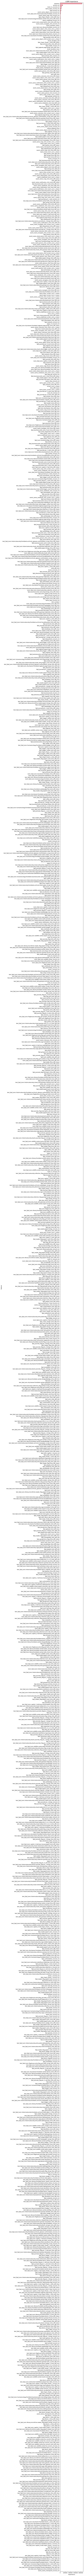

In [36]:
if cfg.mode == "local_cv":
    valid_train_test_process_identity()
    run_train()
inference(cfg.mode)